# Setups, Installations and Imports

In [4]:
# !pip install wandb -q

In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

print('[INFO]', tf.config.experimental.list_physical_devices('GPU')[0])

2.6.0
[INFO] PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: Currently logged in as: lunchb0ne (use `wandb login --relogin` to force relogin)


True

In [3]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid

# Prepare Dataset

In [4]:
## Cifar 10 Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


#### Visualization of Cifar 10

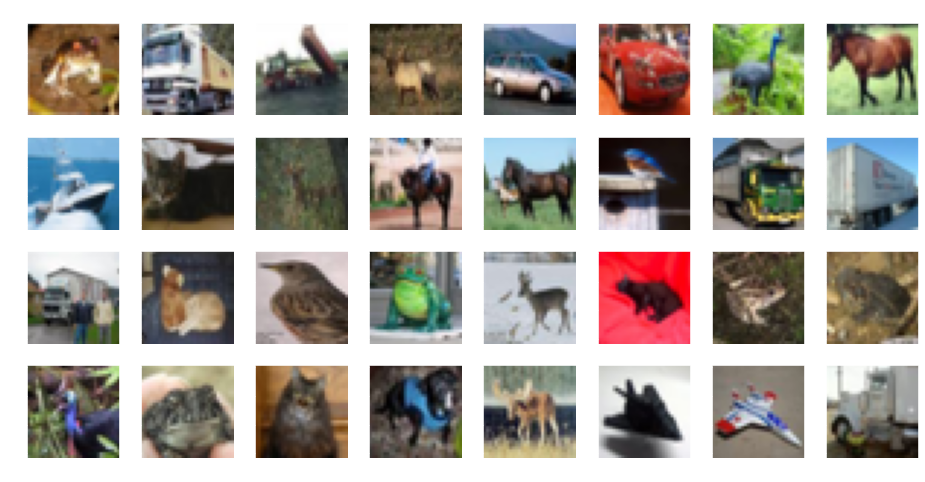

In [5]:
## Get first 32 images as samples
sample_images = x_train[:32]
sample_labels = y_train[:32]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, sample_images, sample_labels):
  ax.imshow(image)
  ax.set_title(label[0])

plt.show()

In [6]:
from utils.createAugment import createAugment

#### Data Generator with Patch Augmentation

In [7]:
## Prepare training and testing mask-image pair generator
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_test, x_test, shuffle=False)

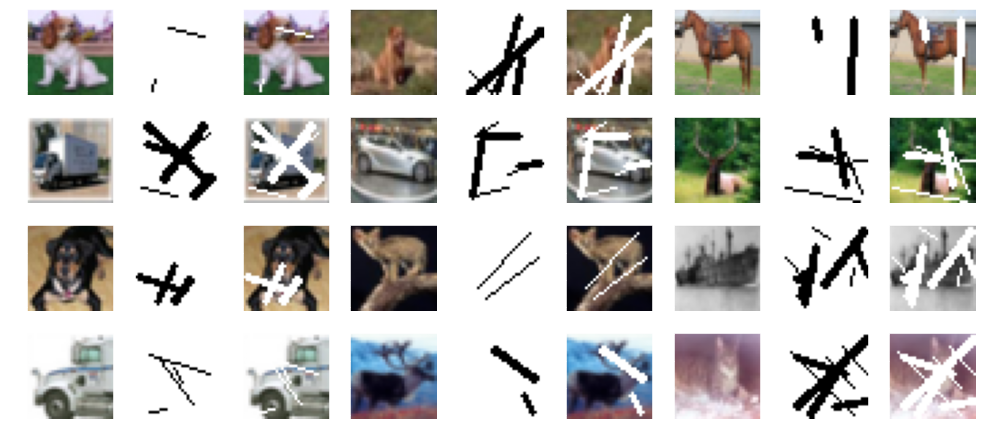

In [8]:
# Legend: Original Image | Mask generated | Masked Image

## Examples
sample_idx = 90 ## Change this to see different batches

[masked_images, masks], sample_labels = traingen[sample_idx]
sample_images = [None]*(len(masked_images)+len(masks)+len(sample_labels))
sample_images[::3] = sample_labels
# masks[]
sample_images[1::3] = masks
sample_images[2::3] = masked_images

fig = plt.figure(figsize=(17., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 9),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

## Partial Convolution Based Autoencoder-Decoder Model

In [9]:
## utils is present in the cloned repo. Visit repo for the implementation of PConv2D.
from utils.pconv_layer import PConv2D

In [10]:
## For more information into formulation: https://www.youtube.com/watch?v=AZr64OxshLo
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [11]:
class InpaintingModel:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(32,32,3)):
    input_image = keras.layers.Input(input_size)
    input_mask = keras.layers.Input(input_size, name='encoder_input')
  
    conv1, mask1, conv2, mask2 = self.__encoder_layer(32, input_image, input_mask, ['conv1', 'conv2'])
    conv3, mask3, conv4, mask4 = self.__encoder_layer(64, conv2, mask2, ['conv3', 'conv4'])
    conv5, mask5, conv6, mask6 = self.__encoder_layer(128, conv4, mask4, ['conv5', 'conv6'])
    conv7, mask7, conv8, mask8 = self.__encoder_layer(256, conv6, mask6, ['conv7', 'encoder_output'])

    conv9, mask9, conv10, mask10 = self.__decoder_layer(256, 128, conv8, mask8, conv7, mask7, ['conv9', 'conv10'])
    conv11, mask11, conv12, mask12 = self.__decoder_layer(128, 64, conv10, mask10, conv5, mask5, ['conv11', 'conv12'])
    conv13, mask13, conv14, mask14 = self.__decoder_layer(64, 32, conv12, mask12, conv3, mask3, ['conv13', 'conv14'])
    conv15, mask15, conv16, mask16 = self.__decoder_layer(32, 3, conv14, mask14, conv1, mask1, ['conv15', 'decoder_output'])

    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv16)

    return keras.models.Model(inputs=[input_image, input_mask], outputs=[outputs])
    
  def __encoder_layer(self, filters, in_layer, in_mask, names):
    conv1, mask1 = PConv2D(32, (3,3), strides=1, padding='same', name=names[0])([in_layer, in_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(32, (3,3), strides=2, padding='same', name=names[1])([conv1, mask1])
    # conv2 = keras.layers.BatchNormalization()(conv2, training=True)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

  def __decoder_layer(self, filter1, filter2, in_img, in_mask, share_img, share_mask, names):
    up_img = keras.layers.UpSampling2D(size=(2,2))(in_img)
    up_mask = keras.layers.UpSampling2D(size=(2,2))(in_mask)
    concat_img = keras.layers.Concatenate(axis=3)([share_img, up_img])
    concat_mask = keras.layers.Concatenate(axis=3)([share_mask, up_mask])

    conv1, mask1 = PConv2D(filter1, (3,3), padding='same', name=names[0])([concat_img, concat_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(filter2, (3,3), padding='same', name=names[1])([conv1, mask1])
    # conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2021-11-21 16:15:02.169423: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-21 16:15:02.169535: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


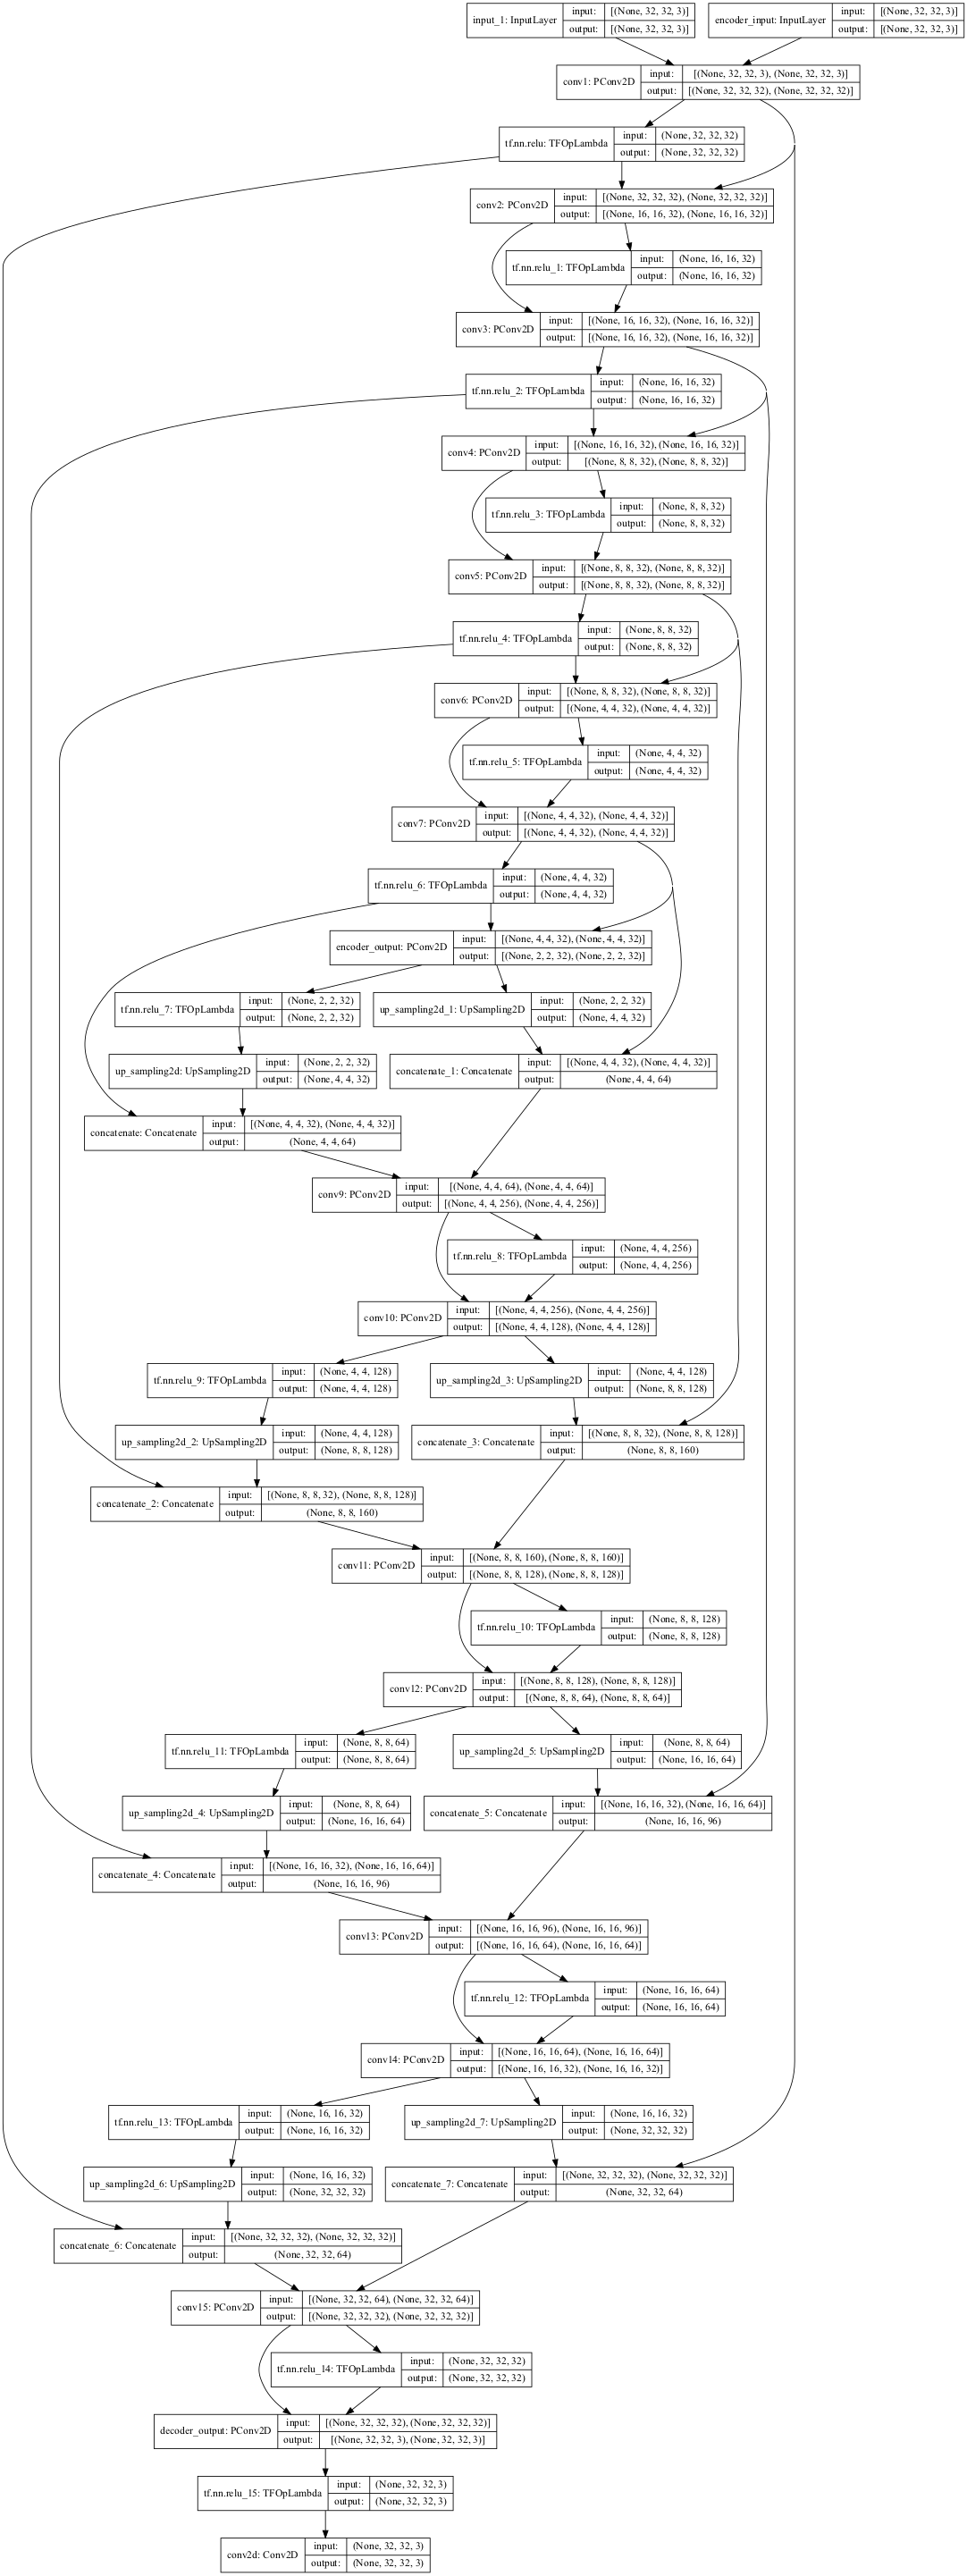

In [12]:
keras.backend.clear_session()
model = InpaintingModel().prepare_model()
model.summary()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi=60, to_file='model_v2.png')

# Train

In [13]:
wandb.init(project="BTP", entity="lunchb0ne")

/opt/homebrew/Caskroom/mambaforge/base/envs/tensorflow/lib/python3.9/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [18]:
class PredictionLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(PredictionLogger, self).__init__()

    def on_epoch_end(self, logs, epoch):
        sample_idx = 54
        [masked_images, masks], sample_labels = testgen[sample_idx]  
        
        m_images = []
        binary_masks = []
        predictions = []
        labels = []
        
        for i in range(32):
          inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
          impainted_image = model.predict(inputs)

          m_images.append(masked_images[i])
          binary_masks.append(masks[i])
          predictions.append(impainted_image.reshape(impainted_image.shape[1:]))
          labels.append(sample_labels[i])

        wandb.log({"masked_images": [wandb.Image(m_image)
                              for m_image in m_images]})
        wandb.log({"masks": [wandb.Image(mask)
                              for mask in binary_masks]})
        wandb.log({"predictions": [wandb.Image(inpainted_image)
                              for inpainted_image in predictions]})
        wandb.log({"labels": [wandb.Image(label)
                              for label in labels]})

In [19]:
_ = model.fit_generator(traingen,
          validation_data=testgen, 
          epochs=20, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen),
          use_multiprocessing=True,
          callbacks=[WandbCallback(),
                     PredictionLogger()])

/opt/homebrew/Caskroom/mambaforge/base/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-11-21 15:55:03.456187: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-21 15:55:03.457390: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/20


2021-11-21 15:55:04.474620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1562/1562 [==============================] - ETA: 0s - loss: 0.1074 - dice_coef: 0.5345

2021-11-21 15:56:43.415991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1562/1562 [==============================] - 110s 66ms/step - loss: 0.1074 - dice_coef: 0.5345 - val_loss: 0.0582 - val_dice_coef: 0.5757


2021-11-21 15:56:53.906247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 2/20
1562/1562 [==============================] - 104s 65ms/step - loss: 0.0480 - dice_coef: 0.5840 - val_loss: 0.0427 - val_dice_coef: 0.5916
Epoch 3/20
1562/1562 [==============================] - 101s 64ms/step - loss: 0.0406 - dice_coef: 0.5916 - val_loss: 0.0390 - val_dice_coef: 0.5953
Epoch 4/20
1562/1562 [==============================] - 101s 63ms/step - loss: 0.0379 - dice_coef: 0.5940 - val_loss: 0.0366 - val_dice_coef: 0.5967
Epoch 5/20
1562/1562 [==============================] - 125s 79ms/step - loss: 0.0361 - dice_coef: 0.5953 - val_loss: 0.0353 - val_dice_coef: 0.5979
Epoch 6/20
1562/1562 [==============================] - 102s 64ms/step - loss: 0.0348 - dice_coef: 0.5962 - val_loss: 0.0342 - val_dice_coef: 0.5972
Epoch 7/20
 331/1562 [=====>........................] - ETA: 12:11 - loss: 0.0340 - dice_coef: 0.5950

Process Keras_worker_SpawnPoolWorker-20:
wandb: WARNING GPU stats error Command '['/opt/homebrew/Caskroom/mambaforge/base/envs/tensorflow/lib/python3.9/site-packages/wandb/bin/apple_gpu_stats', '--json']' died with <Signals.SIGINT: 2>.
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/tensorflow/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/tensorflow/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/tensorflow/lib/python3.9/multiprocessing/pool.py", line 131, in worker
    put((job, i, result))
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/tensorflow/lib/python3.9/multiprocessing/queues.py", line 378, in put
    self._writer.send_bytes(obj)
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/tensorflow/lib/python3.9/multiprocessing/connection.py", li

KeyboardInterrupt: 

Process Keras_worker_SpawnPoolWorker-21:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/tensorflow/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/tensorflow/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/tensorflow/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/tensorflow/lib/python3.9/multiprocessing/queues.py", line 366, in get
    res = self._reader.recv_bytes()
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/tensorflow/lib/python3.9/multiprocessing/connection.py", line 221, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/tensorflow/lib/python3.9/multiprocessing/connection.py", line 419, in _recv_bytes
    buf

# Testing on images

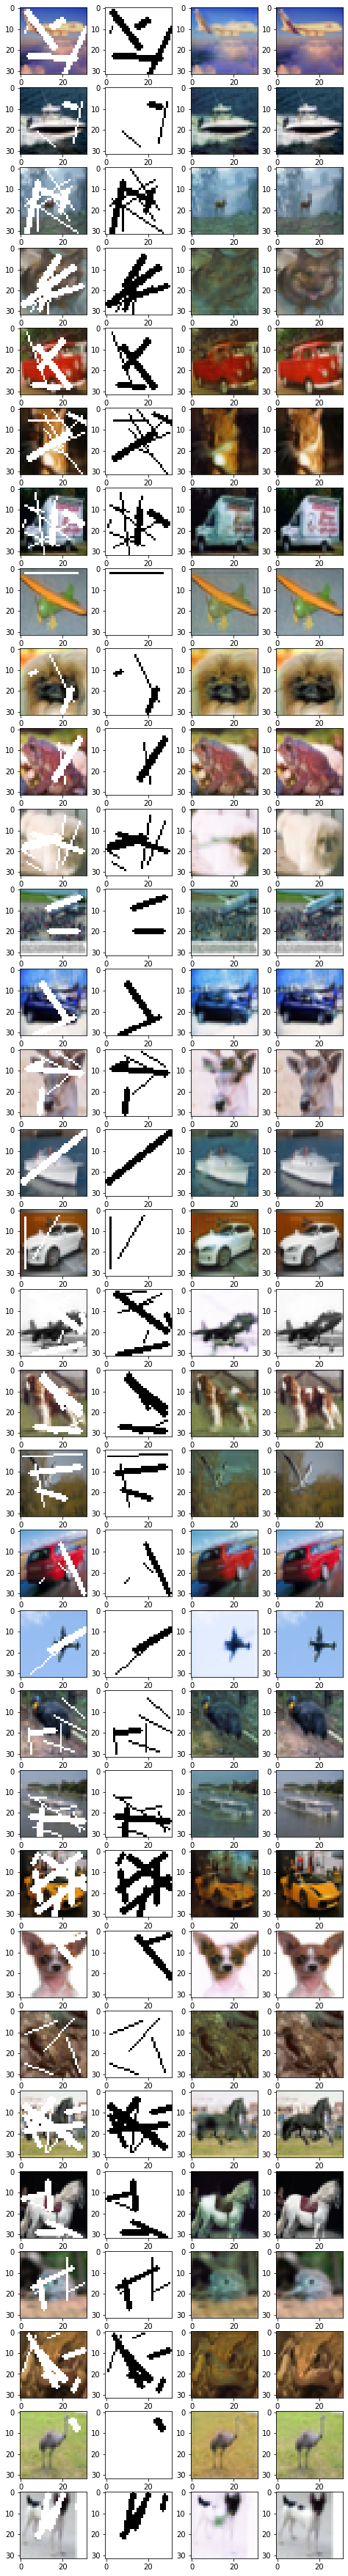

In [ ]:
## Legend: Original Image | Mask generated | Inpainted Image | Ground Truth

## Examples
rows = 32
sample_idx = 54
[masked_images, masks], sample_labels = testgen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(8, 2*rows))

for i in range(32):
  inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
  impainted_image = model.predict(inputs)
  axs[i][0].imshow(masked_images[i])
  axs[i][1].imshow(masks[i])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
  axs[i][3].imshow(sample_labels[i])
  
plt.show()